In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
data = pd.read_csv("/kaggle/input/mytrain/s2annimp.csv")
data

,quizzes,solutions
0,0832954170018000590950008620700009000000700203...,6832954174218673597953416625721349868465771233...
1,1007540310002060070048390500010780000405903100...,1697548323582169477748396515314782967465823189...
2,7000508348000250409300782008798004000004970266...,7126548398659237419348782652798614533584971266...
3,0000930078030000290590824039003502016001007081...,2145936878687415297596824137783542616331297481...
4,6507300901986000070370002860003456020000010742...,6527348913986524374371382569713456823852619742...
...,...,...
49995,0896000576200001000408102060104098239020800000...,1896243576279351845438172964167598239724835613...
49996,7413090080050800402300000701000060276570481903...,7413592689657823412386149751895364276572681933...
49997,2004659101040080000800057034200070080008064919...,2574639181347986256892857438219573863758264919...
49998,9082000000024609706748000507000143800000025003...,9382571461574839786748912537256193844693825173...


In [14]:
import torch.nn as nn
import torch.optim as optim  
import matplotlib.pyplot as plt


**Solving Sudoku with Neural Network Models- Part 2**

Sudoku is a number puzzle game that requires you to fill in digits 1 to 9. The game requires digits 1 to 9 to appear exactly once in each row, column and each of the nine 3x3 subgrids. The project experiment with different neural networks such as CNN. The data have been divided by 9 and subtracted by 0.5 to achieve zero mean-centred data. 

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   quizzes    50000 non-null  object
 1   solutions  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
#checking if there are any null values
data.isnull().values.any()

False

In [5]:
#checking the number of zeros in the puzzle
list(data['quizzes'][0]).count('0')

40

In [6]:
checking the number of zeros in solutions
list(data['solutions'][0]).count('0')

0

In [9]:
number_of_blanks=[]
for i in range(data.shape[0]):
    number_of_blanks.append(list(data['quizzes'][i]).count('0'))
number_of_blanks[:10]

[40, 40, 40, 40, 40, 40, 40, 42, 40, 41]

**Data Preprocessing**

In [10]:
class SudokuDataset(Dataset):
    def __init__(self, dataframe, subset="train"):
        self.dataframe = dataframe
        self.subset = subset

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        puzzle = self.dataframe.iloc[idx, 0]
        solution = self.dataframe.iloc[idx, 1]

        puzzle = torch.tensor([int(p) for p in puzzle], dtype=torch.float32).reshape(1, 9, 9) / 9 - 0.5
        if self.subset == 'train':
            # Subtracting 1 from each solution value to match PyTorch's 0-based indexing
            solution = torch.tensor([int(s) - 1 for s in solution], dtype=torch.int64).reshape(81)
            return puzzle, solution
        return puzzle

In [12]:
train_idx = int(len(data) * 0.80)
train_data = SudokuDataset(data.iloc[:train_idx], subset="train")
train_loader = DataLoader(train_data, batch_size=640, shuffle=True)

val_data = SudokuDataset(data.iloc[train_idx:], subset="train")
val_loader = DataLoader(val_data, batch_size=640, shuffle=False)

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class SudokuSolver(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(SudokuSolver, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(p=0.5)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 9 * 9, 81 * 9)  # Output dimension changed
        self.dropout2 = nn.Dropout(p=0.2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout1(x)
        x = self.dropout2(x)
        x = self.fc1(x)
        x = x.view(-1, 9)  # Reshaped to match [batch_size * 81, 9]
        x = F.softmax(x, dim=1)  # Apply softmax to obtain probabilities
        return x

In [17]:
def train_model(model, train_loader, val_loader, epochs, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for puzzles, solutions in train_loader:
            puzzles, solutions = puzzles.to(device), solutions.to(device)
            optimizer.zero_grad()
            outputs = model(puzzles)
            loss = criterion(outputs, solutions.view(-1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += solutions.size(0)
            correct_train += (predicted == solutions.view(-1)).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for puzzles, solutions in val_loader:
                puzzles, solutions = puzzles.to(device), solutions.to(device)
                outputs = model(puzzles)
                val_loss += criterion(outputs, solutions.view(-1)).item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += solutions.size(0)
                correct_val += (predicted == solutions.view(-1)).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{epochs}: '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {avg_val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SudokuSolver().to(device)
# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, epochs=50, device=device)

Epoch 1/50: Train Loss: 2.1780, Train Accuracy: 12.9759, Validation Loss: 2.1560, Validation Accuracy: 15.1778
Epoch 2/50: Train Loss: 2.1353, Train Accuracy: 17.3625, Validation Loss: 2.1140, Validation Accuracy: 19.3850
Epoch 3/50: Train Loss: 2.0892, Train Accuracy: 21.9249, Validation Loss: 2.0592, Validation Accuracy: 24.9525
Epoch 4/50: Train Loss: 2.0393, Train Accuracy: 26.4071, Validation Loss: 2.0091, Validation Accuracy: 29.1846
Epoch 5/50: Train Loss: 1.9951, Train Accuracy: 30.1442, Validation Loss: 1.9612, Validation Accuracy: 33.1503
Epoch 6/50: Train Loss: 1.9618, Train Accuracy: 32.9285, Validation Loss: 1.9322, Validation Accuracy: 35.5476
Epoch 7/50: Train Loss: 1.9387, Train Accuracy: 34.8504, Validation Loss: 1.9130, Validation Accuracy: 37.0179
Epoch 8/50: Train Loss: 1.9215, Train Accuracy: 36.2317, Validation Loss: 1.8985, Validation Accuracy: 38.1443
Epoch 9/50: Train Loss: 1.9076, Train Accuracy: 37.3457, Validation Loss: 1.8896, Validation Accuracy: 38.8078
E

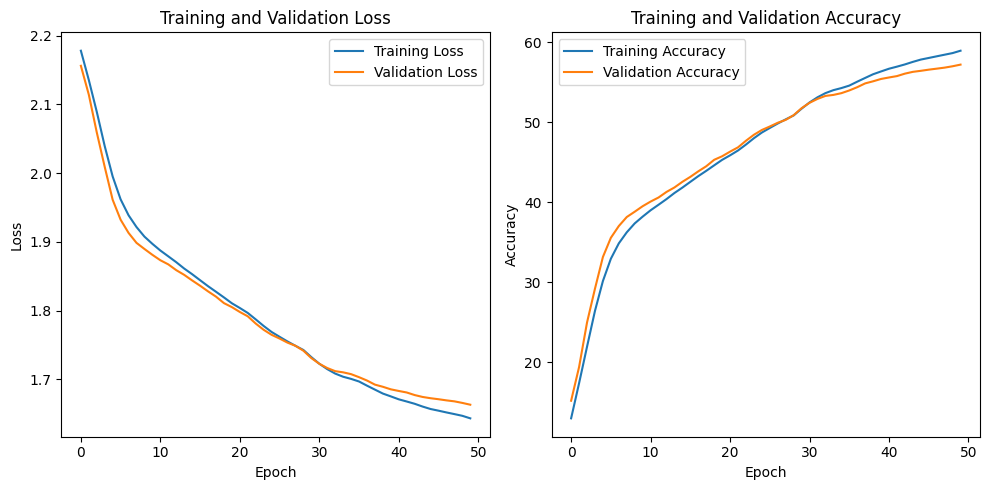

In [18]:
# Plotting
plt.figure(figsize=(10, 5))

# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

From the graphs, it is understandable that, the validationaccuracy is increasing and validation loss is decreasing.So the model is learning at a slow pace.

**Prediction**

In [52]:
import pandas as pd
test=pd.read_csv("/kaggle/input/finaltestmydata/test_predictions (1).csv")
test

,Unnamed: 0,predicted_values
0,0,9027008637614000250800000706070950009106000542...
1,1,0708010200207300001060920040900754800520080038...
2,2,0009001650806000306012437008070950230307046009...
3,3,1580096070000760027264183000157040000040800510...
4,4,0020500096038002059700008361080005032060350800...
...,...,...
9995,9995,0001050300407062100009405607510943060202507040...
9996,9996,1058000404001300056030509170006005315060030092...
9997,9997,0000278000703000900489500367800000040624009783...
9998,9998,0020950000391800001050020980017200803275009164...


In [53]:
model.eval()
predictions = []

for _, row in test.iterrows():
    puzzle_str = row['predicted_values']
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    puzzle_tensor = torch.tensor([int(p) for p in puzzle_str], dtype=torch.float32).reshape(1, 1, 9, 9) / 9 - 0.5
    puzzle_tensor = puzzle_tensor.to(device)  

# Forward pass
    output = model(puzzle_tensor)
    solution = output.argmax(dim=1).view(9, 9) + 1  # Convert predictions to 1-based indexing
    predictions.append(solution.cpu().numpy())  



In [54]:
indexes = []
labels= []
for i,j in enumerate(predictions):
    preds = j.reshape(9,9)
    for row in range(0,9):
        for col in range(0,9):
            index = str(i)+"_"+str(row)+str(col)
            indexes.append(index)
            labels.append(preds[row,col])

In [56]:
Test_Predictions =  {"id":indexes , "values":labels}
Test_Predictions = pd.DataFrame(Test_Predictions)


In [57]:
Test_Predictions

,id,values
0,0_00,9
1,0_01,4
2,0_02,2
3,0_03,7
4,0_04,5
...,...,...
809995,9999_84,8
809996,9999_85,5
809997,9999_86,3
809998,9999_87,9


In [58]:
Test_Predictions.to_csv("prednew77.csv", index=False)